# Go straight to predicting the sentiment of the next utterance

In [138]:
from spacy import displacy

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import spacy
import os
from functools import partial

import data
import plot

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from chatty.utils import tokens

train, train_vecs, test, test_vecs = data.get_data(use_cached=True)

train['utter_len'] = train['utter'].map(lambda x: len(x.split(' ')))

train['has_question_mark'] = train['utter'].map(lambda x: 1 if'?' in x.split(' ') else 0)
train = pd.concat([train, data.get_lags(train[['has_question_mark']], lag_range=[1])], axis=1)
train[['utter_t-3', 'utter_t-2', 'utter_t-1']] = data.get_lags(train[['utter']], lag_range=[3, 2, 1])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using Cached


In [579]:
ACT_MASK = train['act'].notnull() & train['has_question_mark_t-1'].notnull()

assert train['act'][train['act'].notnull()].shape[0] \
      == train_vecs[train['act'].notnull()].shape[0]

TRAIN_MASK = ['first_utterance',
              'subjectivity',
              'utter_len',
              'has_question_mark',
              'has_question_mark_t-1']

X = np.concatenate((train_vecs,
                    train[TRAIN_MASK].values),
                   axis=1)[ACT_MASK]
y = train['act'][ACT_MASK]

### Predict next emo directly from Pipeline RandomForest on words and pos

In [140]:
from sklearn.pipeline import FeatureUnion
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier


from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

from chatty.utils import tokens
# %reload_ext chatty.utils.tokens


vocab = np.array(tokens.load_vocab('subjects_dependency_pos', 'word_ngram_2')['vocab'])


SPLITTER = "*^"
def vocab_splitter(tokens: str):
    return tokens.split(SPLITTER)

LAG_MASK = ['vocab_t-3', 'vocab_t-2', 'vocab_t-1']

train['vocab'] = pd.Series(vocab, index=train.index).map(lambda x: SPLITTER.join(x))
train[LAG_MASK] = data.get_lags(train[['vocab']], lag_range=[3, 2, 1])

ACT_MASK = train['emo'].notnull() \
         & train['vocab_t-1'].notnull() \
         & train['vocab_t-2'].notnull() \
         & train['vocab_t-3'].notnull()

assert train['emo'][train['emo'].notnull()].shape[0] \
      == train_vecs[train['emo'].notnull()].shape[0]


X = train[LAG_MASK][ACT_MASK].values

y = train['emo'][ACT_MASK].values

In [141]:
from chatty.utils.vectorize import CountVectorizerColumnN

fu = FeatureUnion([('vocab_t-3', CountVectorizerColumnN(analyzer=vocab_splitter, colnum=0)),
                   ('vocab_t-2', CountVectorizerColumnN(analyzer=vocab_splitter, colnum=1)),
                   ('vocab_t-1', CountVectorizerColumnN(analyzer=vocab_splitter, colnum=2))])

clf = Pipeline([
    ('feature_union_countvecs', fu),
    ('random', RandomOverSampler('minority')),
    ('RandomForest', RandomForestClassifier(n_jobs=-1))
])

In [63]:
results = data.cv_stratified_shuffle(X, y,
                                     clf,
                                     splits=2)

Training
Training
Training
Training
Training


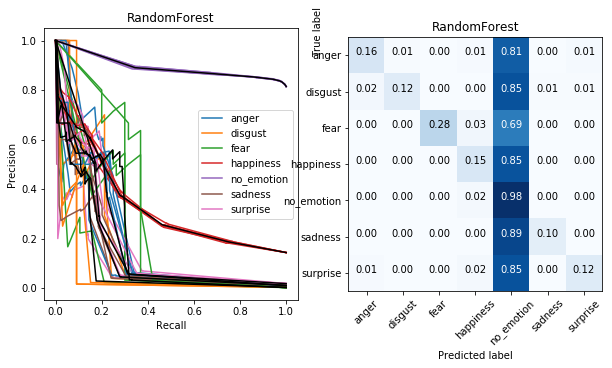

In [64]:
plot.plot_prec_rec(results, "RandomForest", normalize_confusion_matrix=True)

### Gradient Boosted Classifier

In [210]:
from sklearn.pipeline import FeatureUnion
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from chatty.utils import tokens
# %reload_ext chatty.utils.tokens


vocab = np.array(tokens.load_vocab('subjects_dependency_pos', 'word_ngram_2')['vocab'])


SPLITTER = "*^"
def vocab_splitter(tokens: str):
    return tokens.split(SPLITTER)

LAG_MASK = ['vocab_t-3', 'vocab_t-2', 'vocab_t-1']

train['vocab'] = pd.Series(vocab, index=train.index).map(lambda x: SPLITTER.join(x))
train[LAG_MASK] = data.get_lags(train[['vocab']], lag_range=[3, 2, 1])

ACT_MASK = train['emo'].notnull() \
         & train['vocab_t-1'].notnull() \
         & train['vocab_t-2'].notnull() \
         & train['vocab_t-3'].notnull()

assert train['emo'][train['emo'].notnull()].shape[0] \
      == train_vecs[train['emo'].notnull()].shape[0]


X = train[LAG_MASK][ACT_MASK].values

y = train['emo'][ACT_MASK].values

In [212]:
from chatty.utils.vectorize import CountVectorizerColumnN

fu = FeatureUnion([('vocab_t-3', CountVectorizerColumnN(analyzer=vocab_splitter, colnum=0)),
                   ('vocab_t-2', CountVectorizerColumnN(analyzer=vocab_splitter, colnum=1)),
                   ('vocab_t-1', CountVectorizerColumnN(analyzer=vocab_splitter, colnum=2))])

clf = Pipeline([
    ('feature_union_countvecs', fu),
    ('random', RandomOverSampler('minority')),
    ('RandomForest', GradientBoostingClassifier())
])

In [213]:
results = data.cv_stratified_shuffle(X, y,
                                     clf,
                                     splits=2)

Training
Training


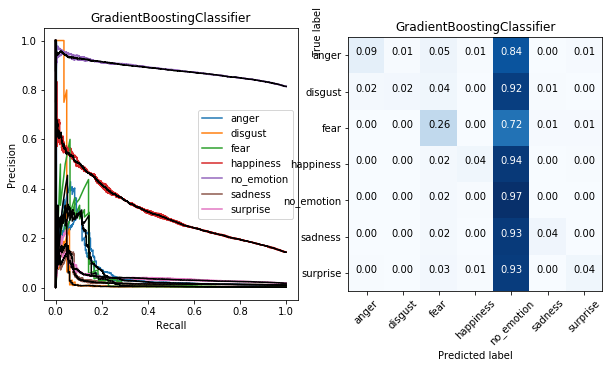

In [216]:
plot.plot_prec_rec(results, "GradientBoostingClassifier", normalize_confusion_matrix=True)

### RandomForest with pos and lemma for both n=[1, 2] ngrams
### 'second_shot'

In [455]:
tokens.list_vocabs()

(['word'],
 ['lemma_', 'lemma_ngram_2', 'pos', 'pos_ngram_2'],
 ['lemma_', 'lemma_ngram_2', 'subjects_dependency_pos'],
 ['subjects_dependency_pos', 'word_ngram_2'])

In [460]:
from sklearn.pipeline import FeatureUnion
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from chatty.utils import tokens
# %reload_ext chatty.utils.tokens


vocab = np.array(tokens.load_vocab('lemma_', 'lemma_ngram_2', 'pos', 'pos_ngram_2')['vocab'])

LAG_MASK = ['vocab_t-3', 'vocab_t-2', 'vocab_t-1']


SPLITTER = "*^"

def vocab_splitter(toks: str):
    return toks.split(SPLITTER)

train['vocab'] = pd.Series(vocab, index=train.index).map(lambda x: SPLITTER.join(x))
train[LAG_MASK] = data.get_lags(train[['vocab']], lag_range=[3, 2, 1])


ACT_MASK = train['emo'].notnull() \
         & train['vocab_t-1'].notnull() \
         & train['vocab_t-2'].notnull() \
         & train['vocab_t-3'].notnull()

assert train['emo'][train['emo'].notnull()].shape[0] \
      == train_vecs[train['emo'].notnull()].shape[0]


X = train[LAG_MASK][ACT_MASK].values
y = train['emo'][ACT_MASK].values

In [461]:
from chatty.utils.vectorize import CountVectorizerColumnN

fu = FeatureUnion([('vocab_t-3', CountVectorizerColumnN(analyzer=vocab_splitter, colnum=0)),
                   ('vocab_t-2', CountVectorizerColumnN(analyzer=vocab_splitter, colnum=1)),
                   ('vocab_t-1', CountVectorizerColumnN(analyzer=vocab_splitter, colnum=2))])

clf = Pipeline([
    ('feature_union_countvecs', fu),
    ('random', RandomOverSampler('minority')),
    ('RandomForest', RandomForestClassifier(n_jobs=-1, verbose=True))
])

results = data.cv_stratified_shuffle(X, y,
                                     clf,
                                     splits=2)

Training


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.7min finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.5s finished


Training


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.4min finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.5s finished


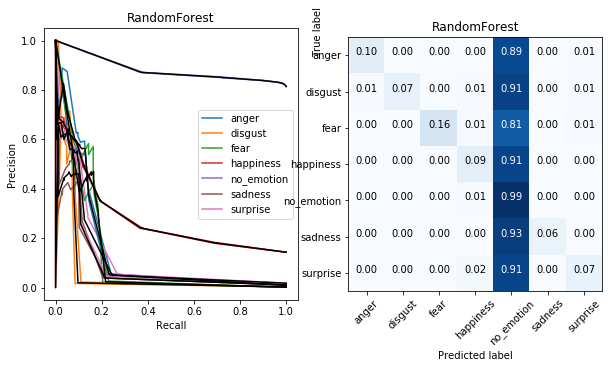

In [462]:
plot.plot_prec_rec(results, "RandomForest", normalize_confusion_matrix=True)

In [463]:
names = results['models'][0].named_steps['feature_union_countvecs'].get_feature_names()

importances = results['models'][0].named_steps['RandomForest'].feature_importances_

In [557]:
list(filter(lambda x: x[0] < 50, enumerate(sorted(zip(names, importances), key=lambda x: x[1], reverse=True))))

[(0, ('vocab_t-3__POS_VERB_POS_VERB', 0.005132606105705047)),
 (1, ('vocab_t-3__LEMMA_ ', 0.004300015643510094)),
 (2, ("vocab_t-3__LEMMA_'", 0.004128706142921603)),
 (3, ('vocab_t-2__POS_ADJ', 0.004052955534455265)),
 (4, ('vocab_t-2__POS_PRON', 0.0038485131587493227)),
 (5, ('vocab_t-3__LEMMA_what_LEMMA_do', 0.0038022236639495763)),
 (6, ('vocab_t-2__POS_PRON_POS_VERB', 0.0038017511982722735)),
 (7, ('vocab_t-2__LEMMA_-PRON-_LEMMA_mean', 0.0036919728084139265)),
 (8, ('vocab_t-3__POS_VERB', 0.003637044899102644)),
 (9, ('vocab_t-1__POS_VERB_POS_ADJ', 0.0033607246945840338)),
 (10, ('vocab_t-2__LEMMA_see', 0.0033333414458138824)),
 (11, ('vocab_t-3__LEMMA_voting', 0.00315028112748606)),
 (12, ('vocab_t-2__POS_ADP', 0.0031286411313772118)),
 (13, ('vocab_t-2__POS_NOUN', 0.0030887238496897034)),
 (14, ('vocab_t-2__POS_NOUN_POS_PUNCT', 0.00306942580681876)),
 (15, ('vocab_t-3__POS_ADV_POS_PUNCT', 0.0030506442410308957)),
 (16, ('vocab_t-3__LEMMA_,_LEMMA_calm', 0.003032767464105561)),
 (1

(0, 2000)

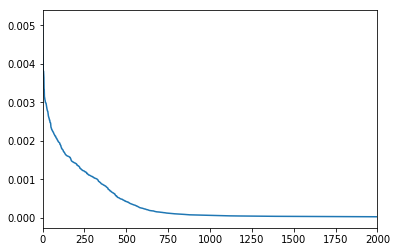

In [465]:
plt.plot(sorted(importances, reverse=True))
plt.xlim(0, 2000)

In [480]:
a = results['models'][0].steps[2][1]

In [482]:
df_results = data.results_to_df(results)

In [481]:
a.decision_path()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=True,
            warm_start=False)

In [492]:
df = data.results_to_df(results)
RESULTS_MASK = ['utter_t-3', 'utter_t-2', 'utter_t-1', 'utter', 'polarity', 'vocab_t-3', 'vocab_t-2', 'vocab_t-1']
new_cols = RESULTS_MASK + list(df.columns)
df = pd.concat([train[ACT_MASK][RESULTS_MASK].reset_index(drop=True), df], ignore_index=True, axis=1)
df.columns = new_cols

y_pred = df[['anger', 'disgust', 'fear', 'happiness', 'no_emotion', 'sadness', 'surprise']].idxmax(axis=1)

##### When I misclassify happy or sad as 'no_emotion' what am I missing?

In [494]:
scrut = df[(y_pred == 'no_emotion') & (df['y_true'].isin({'happiness', 'sadness'}))].sort_values('no_emotion', ascending=False)

In [507]:
pd.set_option('display.max_colwidth', -1)

In [509]:
scrut.sample(10)[['utter_t-3', 'utter_t-2', 'utter_t-1', 'utter', 'happiness', 'sadness', 'polarity']]

,utter_t-3,utter_t-2,utter_t-1,utter,happiness,sadness,polarity
42824,How can I help you ?,"I'd like two sandwiches and one green fruit salad , please .","Will that be all , sir ?",No . Could you also get some extra towels and soup too ? We went to the pool today and used up our two clean towels .,0.100000,0.0,0.183333
2815,What does it come with standard ?,"On all our new cars , the standards include",Cruise control ? I don't like that .,"Why not , sir ?",0.100000,0.0,0.000000
2116,I'm afraid it's too narrow across the shoulders . Do you have a larger one ?,Yes . This one must fit you .,It's a bit loose . Do you have a middle size ?,"I'm afraid not , sir .",0.000000,0.0,-0.600000
22863,"Just a few Christmas gifts , ’ tis the season , after all !",Don ’ t take that tone with me . Do you have an invoice for these items ?,Umm ... no ... I make these in my workshop in the North Pole !,"You are under arrest , sir . You have the right to remain silent . You better not pout , you better not cry . Anything you say can and will be used against you . You have the right to an attorney . if you cannot afford one , the state will appoint one for you.do you understand the arrest to you ?",0.000000,0.0,0.210204
8758,"There aren't enough buses in this city , are there ?","Yeah , sometimes I really feel like writing a letter to the mayor .",That's too much of hassle . We just want a little bigger parking space .,"Have you taken this to the property management , yet ?",0.000000,0.0,0.000000
4209,"May I have the bill , please ?",Here is it .,How much altogether ?,The total amount is $ 185 .,0.216667,0.0,0.000000
26,I'm afraid there's been a mistake .,"I'm sorry , sir . What seems to be the trouble ?","I believe you have charged me twice for the same thing . Look , the figure of 6.5 dollar appears here , then again here .","I'll just go and check it for you , sir .",0.200000,0.0,0.000000
36640,We're supposed to meet him at Cal's Bar at 10,Wait a minute . Cal's bar ?,Yes .,That's a gay bar .,0.000000,0.0,0.416667
44614,"Well , as they say , garbage in , garbage out . Let me correct this error , please .",Thank you . It's very nice when problems can be solved quickly .,"When I deleted the $ 10 , the computer automatically added a $ 2 service charge .",Are you crazy ? You made the mistake and now you're charging me for your mistake ?,0.300000,0.0,-0.600000
22862,"Step out of the vehicle , please . Sir , what do you have in the back ?","Just a few Christmas gifts , ’ tis the season , after all !",Don ’ t take that tone with me . Do you have an invoice for these items ?,Umm ... no ... I make these in my workshop in the North Pole !,0.100000,0.0,0.000000


In [497]:
scrut['vocab_t-1'].iloc[0]

"LEMMA_ _LEMMA_do*^LEMMA_do_LEMMA_7*^LEMMA_7_LEMMA_o'clock*^LEMMA_o'clock_LEMMA_suit*^LEMMA_suit_LEMMA_-PRON-*^LEMMA_-PRON-_LEMMA_?*^LEMMA_ *^LEMMA_do*^LEMMA_7*^LEMMA_o'clock*^LEMMA_suit*^LEMMA_-PRON-*^LEMMA_?*^POS_SPACE_POS_VERB*^POS_VERB_POS_NUM*^POS_NUM_POS_NOUN*^POS_NOUN_POS_NOUN*^POS_NOUN_POS_PRON*^POS_PRON_POS_PUNCT*^POS_SPACE*^POS_VERB*^POS_NUM*^POS_NOUN*^POS_NOUN*^POS_PRON*^POS_PUNCT"

### RandomForest with pos and lemma for both n=[1, 2] ngrams PLUS dependency tree
### Third Shot

In [558]:
tokens.list_vocabs()

(['dependencies', 'lemma_', 'lemma_ngram_2', 'pos', 'pos_ngram_2'],
 ['word'],
 ['lemma_', 'lemma_ngram_2', 'pos', 'pos_ngram_2'],
 ['lemma_', 'lemma_ngram_2', 'subjects_dependency_pos'],
 ['subjects_dependency_pos', 'word_ngram_2'])

In [559]:
from sklearn.pipeline import FeatureUnion
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from chatty.utils import tokens
# %reload_ext chatty.utils.tokens


vocab = np.array(tokens.load_vocab('dependencies', 'lemma_', 'lemma_ngram_2', 'pos', 'pos_ngram_2')['vocab'])

LAG_MASK = ['vocab_t-3', 'vocab_t-2', 'vocab_t-1']


SPLITTER = "*^"

def vocab_splitter(toks: str):
    return toks.split(SPLITTER)

train['vocab'] = pd.Series(vocab, index=train.index).map(lambda x: SPLITTER.join(x))
train[LAG_MASK] = data.get_lags(train[['vocab']], lag_range=[3, 2, 1])


ACT_MASK = train['emo'].notnull() \
         & train['vocab_t-1'].notnull() \
         & train['vocab_t-2'].notnull() \
         & train['vocab_t-3'].notnull()

assert train['emo'][train['emo'].notnull()].shape[0] \
      == train_vecs[train['emo'].notnull()].shape[0]


X = train[LAG_MASK][ACT_MASK].values
y = train['emo'][ACT_MASK].values

In [560]:
from chatty.utils.vectorize import CountVectorizerColumnN

fu = FeatureUnion([('vocab_t-3', CountVectorizerColumnN(analyzer=vocab_splitter, colnum=0)),
                   ('vocab_t-2', CountVectorizerColumnN(analyzer=vocab_splitter, colnum=1)),
                   ('vocab_t-1', CountVectorizerColumnN(analyzer=vocab_splitter, colnum=2))])

clf = Pipeline([
    ('feature_union_countvecs', fu),
    ('random', RandomOverSampler('minority')),
    ('RandomForest', RandomForestClassifier(n_jobs=-1, verbose=True))
])

results = data.cv_stratified_shuffle(X, y,
                                     clf,
                                     splits=2)

Training


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   36.9s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.3s finished


Training


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   33.9s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.3s finished


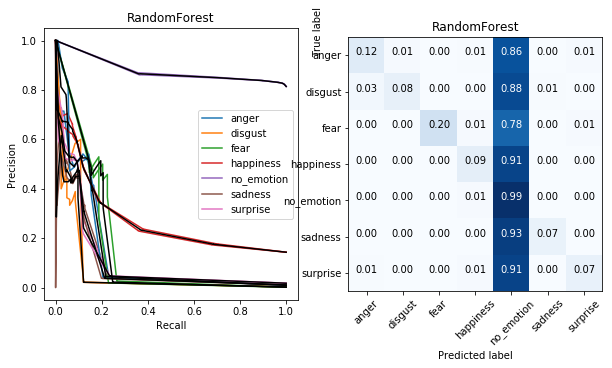

In [561]:
plot.plot_prec_rec(results, "RandomForest", normalize_confusion_matrix=True)

In [562]:
names = results['models'][0].named_steps['feature_union_countvecs'].get_feature_names()

importances = results['models'][0].named_steps['RandomForest'].feature_importances_

In [563]:
list(filter(lambda x: x[0] < 50, enumerate(sorted(zip(names, importances), key=lambda x: x[1], reverse=True))))

[(0, ('vocab_t-2__SPACE/ <---- PRON/PRP', 0.007852567338535758)),
 (1, ('vocab_t-3__LEMMA_do_LEMMA_not', 0.005324030088364023)),
 (2, ('vocab_t-1__POS_VERB_POS_ADV', 0.004844807796710397)),
 (3, ('vocab_t-2__PRON/PRP <--nsubj-- VERB/VBD', 0.004835292193837982)),
 (4, ('vocab_t-2__POS_PRON_POS_VERB', 0.004609399423147141)),
 (5, ('vocab_t-1__DET/DT <--det-- NOUN/NN', 0.004526158247726342)),
 (6, ('vocab_t-3__VERB/VB <--xcomp-- VERB/VBP', 0.004499289540969889)),
 (7, ('vocab_t-3__POS_VERB_POS_PART', 0.0043307623354758825)),
 (8, ('vocab_t-2__POS_PUNCT_POS_PRON', 0.004271436759343684)),
 (9, ('vocab_t-2__LEMMA_see', 0.003957216784291781)),
 (10, ('vocab_t-3__LEMMA_what', 0.003885881401830737)),
 (11, ('vocab_t-3__SPACE/ <---- INTJ/UH', 0.003546019598614799)),
 (12, ('vocab_t-1__POS_PRON', 0.0034333061546992422)),
 (13, ('vocab_t-1__LEMMA_sound', 0.003425833232269651)),
 (14, ('vocab_t-1__LEMMA_house', 0.0033243080767548653)),
 (15, ('vocab_t-3__LEMMA_thing_LEMMA_will', 0.00328120651095163

(0, 2000)

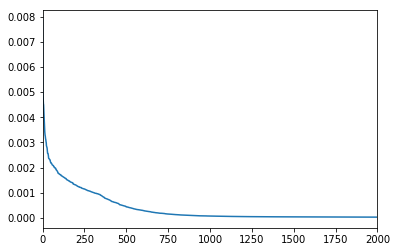

In [564]:
plt.plot(sorted(importances, reverse=True))
plt.xlim(0, 2000)

### detailed scrutiny

In [223]:
train.columns

Index(['person', 'utter', 'act', 'emo', 'polarity', 'subjectivity', 'topic',
       'first_utterance', 'biggest_drawup', 'biggest_drawdown', 'utter_len',
       'has_question_mark', 'has_question_mark_t-1', 'utter_t-3', 'utter_t-2',
       'utter_t-1', 'vocab', 'vocab_t-3', 'vocab_t-2', 'vocab_t-1'],
      dtype='object')

In [257]:
df = data.results_to_df(results)
RESULTS_MASK = ['utter_t-3', 'utter_t-2', 'utter_t-1', 'polarity', 'vocab_t-3', 'vocab_t-2', 'vocab_t-1']
new_cols = RESULTS_MASK + list(df.columns)
df = pd.concat([train[ACT_MASK][RESULTS_MASK].reset_index(drop=True), df], ignore_index=True, axis=1)
df.columns = new_cols

y_pred = df[['anger', 'disgust', 'fear', 'happiness', 'no_emotion', 'sadness', 'surprise']].idxmax(axis=1)

##### When I misclassify happy or sad as 'no_emotion' what am I missing?

In [258]:
df[(y_pred == 'no_emotion') & (df['y_true'].isin({'happiness', 'sadness'}))]

,utter_t-3,utter_t-2,utter_t-1,polarity,vocab_t-3,vocab_t-2,vocab_t-1,y_true,anger,disgust,fear,happiness,no_emotion,sadness,surprise
5,"I swear , I ’ m going to kill you for this .",What ’ s wrong ? Didn ’ t you think it was fu...,"Oh , yeah ! I had a blast ! I love sweating l...",0.000000,ROOT_swear_ROOTPOS_VERB_POS_PRON_DEP_nsubj*^RO...,ROOT_s_ROOTPOS_VERB_POS_NOUN_DEP_nsubj*^ROOT_t...,ROOT_had_ROOTPOS_VERB_POS_PRON_DEP_nsubj*^ROOT...,happiness,0.0,0.0,0.0,0.200000,0.800000,0.0,0.0
6,What ’ s wrong ? Didn ’ t you think it was fu...,"Oh , yeah ! I had a blast ! I love sweating l...","Oh , no , get off it . It wasn ’ t such a kil...",0.000000,ROOT_s_ROOTPOS_VERB_POS_NOUN_DEP_nsubj*^ROOT_t...,ROOT_had_ROOTPOS_VERB_POS_PRON_DEP_nsubj*^ROOT...,ROOT_get_ROOTPOS_VERB_POS_PRON_DEP_pobj*^ROOT_...,happiness,0.0,0.0,0.0,0.100000,0.900000,0.0,0.0
16,According to some studies it may cause cancer .,"Oh , don't let that worry you . If that were ...",I just happen to have a question for you guys...,0.250000,ROOT_cause_ROOTPOS_VERB_POS_NOUN_DEP_pobj*^ROO...,ROOT_let_ROOTPOS_VERB_POS_DET_DEP_nsubj*^ROOT_...,ROOT_happen_ROOTPOS_VERB_POS_PRON_DEP_nsubj*^R...,happiness,0.0,0.0,0.0,0.100000,0.900000,0.0,0.0
20,"Would you like to take a look at the menu , si...",Yes . Thank you .,Would you care for a drink before you order ?,0.000000,ROOT_like_ROOTPOS_VERB_POS_PRON_DEP_nsubj*^ROO...,ROOT_Thank_ROOTPOS_VERB_POS_PRON_DEP_dobj*^LEM...,ROOT_care_ROOTPOS_VERB_POS_PRON_DEP_nsubj*^ROO...,sadness,0.1,0.0,0.0,0.000000,0.900000,0.0,0.0
22,Would you care for a drink before you order ?,A glass of Qingdao beer .,"Yes , sir . I'll bring it over . Have you dec...",0.000000,ROOT_care_ROOTPOS_VERB_POS_PRON_DEP_nsubj*^ROO...,ROOT_glass_ROOTPOS_NOUN_POS_NOUN_DEP_pobj*^LEM...,ROOT_bring_ROOTPOS_VERB_POS_PRON_DEP_nsubj*^RO...,happiness,0.0,0.0,0.0,0.100000,0.900000,0.0,0.0
24,"Could I have my bill , please ?","Certainly , sir .",I'm afraid there's been a mistake .,-0.350000,ROOT_have_ROOTPOS_VERB_POS_PRON_DEP_nsubj*^ROO...,"LEMMA_ *^LEMMA_certainly*^LEMMA_,*^LEMMA_sir*^...",ROOT_'m_ROOTPOS_VERB_POS_PRON_DEP_nsubj*^LEMMA...,happiness,0.0,0.0,0.0,0.100000,0.900000,0.0,0.0
27,Is everything to your satisfaction ?,"No , the steak was recommended , but it is no...",Oh ! Sorry to hear that . This is quite unusu...,-0.275000,ROOT_Is_ROOTPOS_VERB_POS_NOUN_DEP_nsubj*^ROOT_...,ROOT_recommended_ROOTPOS_VERB_POS_PRON_DEP_nsu...,ROOT_Sorry_ROOTPOS_INTJ_POS_DET_DEP_dobj*^ROOT...,happiness,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0
33,Dahua's Market . How can I help you ?,Where is your store located ?,"We are on Nanjing Road , next to the theatre .",0.285714,ROOT_help_ROOTPOS_VERB_POS_PRON_DEP_nsubj*^ROO...,LEMMA_ *^LEMMA_where*^LEMMA_be*^LEMMA_-PRON-*^...,ROOT_are_ROOTPOS_VERB_POS_PRON_DEP_nsubj*^ROOT...,happiness,0.0,0.0,0.0,0.100000,0.900000,0.0,0.0
37,"We have all shapes , sizes , qualities and pr...","I think so . Aren't the four Cs , cut , clari...",You've got it . Tell me a little bit about wh...,-0.100000,ROOT_know_ROOTPOS_VERB_POS_PRON_DEP_nsubj*^ROO...,ROOT_think_ROOTPOS_VERB_POS_PRON_DEP_nsubj*^RO...,ROOT_got_ROOTPOS_VERB_POS_PRON_DEP_nsubj*^ROOT...,happiness,0.0,0.0,0.0,0.200000,0.800000,0.0,0.0
40,I think I going to need some iced water too . ...,"Yes , we charge 50 cents for water .",That's fine . Could you give me some more nap...,0.500000,ROOT_think_ROOTPOS_VERB_POS_PRON_DEP_nsubj*^RO...,ROOT_charge_ROOTPOS_VERB_POS_PRON_DEP_nsubj*^R...,ROOT_'s_ROOTPOS_VERB_POS_DET_DEP_nsubj*^ROOT_g...,happiness,0.0,0.0,0.0,0.166667,0.833333,0.0,0.0


### Feedback from Orson

- Difference in distribution of features like:
    - Word Length
    - Noun Count
    - Verb Count
    - Etc.
- 